# Kwantyzacja kolorów

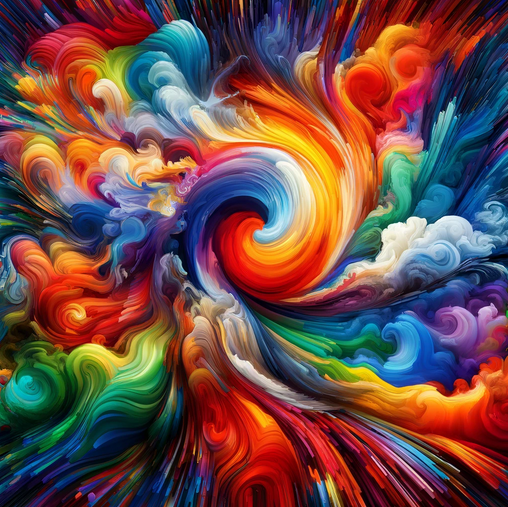

## Wstęp
Standardowy kolorowy obraz rozmiarów $n \times m$ jest reprezentowany przez $n \cdot m \cdot 3$ liczb całkowitych z przedziału $[0, 255]$. Daje to łącznie ponad 16 milionów możliwych kolorów. Kwantyzacja kolorów polega na drastycznym zredukowaniu liczby używanych kolorów w celu redukcji rozmiaru pliku, przy jednoczesnym jak najlepszym zachowaniu jakości obrazu.
Najprostszą metodą kwantyzacji jest użycie metody $k$-means. Działa znakomicie jeśli chodzi o redukcję kolorów, jednak jej natura wpływa też na ostateczny wygląd obrazka:


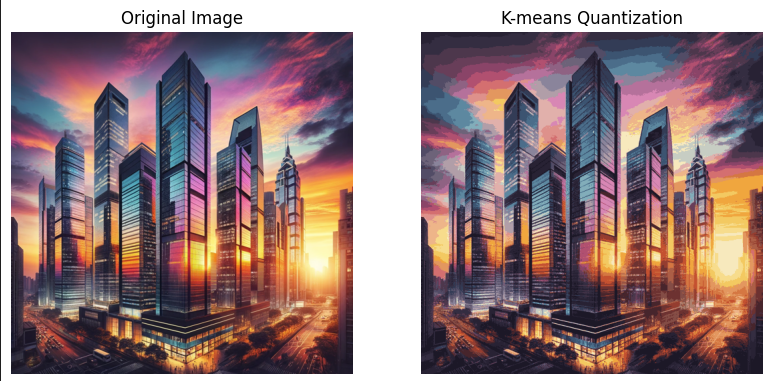


Metoda ([$k$-means](https://en.wikipedia.org/wiki/K-means_clustering)) kwantyzuje obraz minimalizując błąd średniokwadratowy ([mean squared error - MSE](https://en.wikipedia.org/wiki/Mean_squared_error)) pomiędzy oryginalnym a zrekonstruowanym obrazkiem. 
Jednakże zupełnie nie obchodzi jej jakich kolorów ostatecznie użyje. Okazuje się jednak, że jeśli narzucimy koszty użycia kolorów to będziemy w stanie wpłynąć na jakość kwantyzacji. Wtedy jednak metoda $k$-means nie będzie już optymalna.

Zmiana metody kwantyzacji może więc wpłynąć na ostateczną jakość skwantyzowanego obrazu. I o tym właśnie jest poniższe zadanie.


## Zadanie

Celem zadania jest napisanie algorytmu klasteryzacji, który minimalizuje inną funkcję celu niż $k$-means.
Na początek zdefiniujmy sobie *koszt koloru*. Kolor RGB rozumiemy jako wektor trójwymiarowy ze zbioru $[0,1,...,255]^3$, a koszt koloru $c$ zdefiniujemy jako
odległość euklidesową od najbliższego "prostego" koloru w przestrzeni RGB, gdzie prostymi kolorami nazywamy: czarny $(0,0,0)$, biały $(255,255,255)$, czerwony $(255,0,0)$, zielony $(0,255,0)$, niebieski $(0,0,255)$, żółty $(255,255,0)$, magenta $(255,0,255)$ oraz cyjan $(0,255,255)$. Szczegóły znajdziesz w funkcji `color_cost`.
Z tak zdefiniowaną funkcją kosztu najbardziej kosztowny kolor to $(127,127,127)$, czyli szary. 
Interpretacja tej funkcji kosztu jest więc taka, że będziemy chcieli wymusić na algorytmie kwantyzacji, aby preferował kolory, które są bardziej jaskrawe i żywe.

Naszą funkcją celu będzie ważona suma poszczególnych składników:
1. `MSE`: błąd średniokwadratowy pomiędzy oryginalnym a zrekonstruowanym obrazkiem --- ten składnik odpowiada za to, żeby skwantyzowany obraz był bliski oryginałowi.
2. `max_color_cost`: największy z kosztów użytych kolorów --- ten składnik wzmacnia jaskrawość kolorów, poprzez kontrolę najmniej jaskrawego koloru.
3. `mean_color_cost`: średni koszt koloru liczony po wszystkich pikselach --- ten składnik wymusza, aby użyte kolory były średnio odpowiednio jaskrawe.

Ostatecznym kryterium jakości kwantyzacji będzie $$2\cdot MSE  + 21\cdot max\_color\_cost + 42\cdot mean\_color\_cost.$$

Powyższe kryterium i wszystkie funkcje, o których powyżej jest mowa, są zaimplementowane poniżej przez nas. 

W zadaniu zakładamy, że liczba kolorów jest z góry ustalona i wynosi $37$. Twój algorytm ma więc skwantyzować obraz na $37$ kolorów w taki sposób, aby zminimalizować powyższą funkcję celu.


## Ograniczenia
- W tym zadaniu możesz korzystać z GPU.
- Twoja funkcja powinna zwracać 5 skwantyzowanych obrazów w maksymalnie 3 minuty używając Google Colab z GPU.
- Zarówno oryginalny i skwantyzowany obrazek powinny być podane do funkcji ewaluacyjnej jako `np.array` typu `np.uint8` z wartościami z przedziału $[0, 255]$.

## Uwagi i wskazówki
- Każdy obrazek to indywidualny zbiór treningowy; podczas ewaluacji nie będą wczytywane żadne wagi wytrenowanych przez Ciebie modeli.
- Będziesz pracować na obrazach wygenerowanych przez DALL-E oraz Stable Diffusion.
- W funkcji `your_quantization_algorithm` należy ustawić seeda, aby wyniki otrzymane na zbiorze treningowym i walidacyjnym przenosiły się na testowy.

## Pliki zgłoszeniowe
Tylko ten notebook.

## Ewaluacja
Pamiętaj, że podczas sprawdzania flaga `FINAL_EVALUATION_MODE` zostanie ustawiona na `True`. Za pomocą skryptu `evaluation_script.py` będziesz mógł upewnić się, że Twoje rozwiązanie zostanie prawidłowo wykonane na naszych serwerach oceniających. 

Za to zadanie możesz zdobyć pomiędzy 0 i 1.5 punktu. Jeśli dostaniesz score powyżej 8900, to dostaniesz 0, a jeśli poniżej 8000, to dostaniesz 1.5 punktu. Pomiędzy tymi wartościami, Twój wynik maleje liniowo z wartością score.



# Kod startowy

In [ ]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI PODCZAS WYSYŁANIA ##########################
FINAL_EVALUATION_MODE = False
# W czasie sprawdzania Twojego rozwiązania, zmienimy tę wartość na True
# Wartość tej flagi M U S I zostać ustawiona na False w rozwiązaniu, które nam nadeślesz!

In [ ]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
import os
import numpy as np
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import typing

import glob

## Ładowanie danych

In [ ]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################


# Klasa, która ułatwia wczytywanie obrazków z danego folderu
class ImageDataset:
    def __init__(self, image_dir: str):
        self.filelist = glob.glob(image_dir + "/*.jpg")
        self.IMAGE_DIMS = (512, 512)

    def __len__(self):
        return len(self.filelist)

    def __getitem__(self, idx) -> np.ndarray:
        with Image.open(self.filelist[idx]) as image:
            image = image.convert("RGB")
            image = image.resize(self.IMAGE_DIMS)
            return np.array(image)

    def __iter__(self) -> typing.Iterator[np.ndarray]:
        return (self[i] for i in range(len(self.filelist)))

## Kod z kryterium oceniającym

In [ ]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

# Poniżej znajdziesz definicje MSE oraz kosztu użycia kolorów
# Pamiętaj, żeby przy ewaluacji liczyć je w przestrzeni RGB, tzn. na wartościach całkowitych z przdziału [0, 255]
# Skalowanie jest dopuszczalne tylko podczas treningu!


# Zdefiniujmy kryterium oceny jakości kwantyzacji
# Użyjemy do tego błędu średniokwadratowego (mean square error - MSE)
def mse(img, img_quant):
    return ((img_quant.astype(np.float32) - img.astype(np.float32)) ** 2).mean()


# Następnie zdefinujmy koszt użycia kolorów
# Im bliżej danemu kolorowi do "prostych" kolorów, tym mniejszy koszt jego użycia
def color_cost(img_quant):
    vertices = np.array(
        [
            [0, 0, 0],
            [0, 0, 255],
            [0, 255, 0],
            [0, 255, 255],
            [255, 0, 0],
            [255, 0, 255],
            [255, 255, 0],
            [255, 255, 255],
        ]
    )

    pixels = img_quant.reshape(-1, 3)

    differences = pixels[:, np.newaxis, :] - vertices[np.newaxis, :, :]
    squared_distances = np.sum(differences**2, axis=2)
    costs = np.sqrt(np.min(squared_distances, axis=1))

    return np.mean(costs), np.max(costs)


# Całkowite kryterium zdefiniowane w treści zadania
def quantization_score(img, img_quant):
    assert img.dtype == np.uint8
    assert img_quant.dtype == np.uint8
    assert len(np.unique(img_quant.reshape(-1, 3), axis=0)) == 37

    mse_cost = mse(img, img_quant)
    mean_color_cost, max_color_cost = color_cost(img_quant)
    score = mse_cost * 2 + max_color_cost * 21 + mean_color_cost * 42
    print(
        f"MSE: {mse_cost:.4f}, max_color_cost: {max_color_cost:.4f}, mean_color_cost: {mean_color_cost:.4f}"
    )
    print(f"Score: {score:.4f}")
    return score

# Twoje rozwiązanie

Ta sekcja to miejsce na Twoje rozwiązanie. Tylko tutaj powinieneś wprowadzać zmiany!

In [ ]:
"""
ROZWIĄZANIE ZADANIA KWANTYZACJI KOLORÓW - OLIMPIADA SZTUCZNEJ INTELIGENCJI

Opis problemu:
- Zadanie polega na redukcji liczby kolorów w obrazie do dokładnie 37 kolorów
- Funkcja oceny uwzględnia błąd średniokwadratowy oraz koszt kolorów (odległość od kolorów podstawowych)
- Celem jest minimalizacja funkcji: 2*MSE + 21*max_color_cost + 42*mean_color_cost

Podejście rozwiązania:
Zastosowano głęboką sieć neuronową konwolucyjną, która dla każdego obrazu generuje 37 kolorów
reprezentatywnych. Sieć jest trenowana bezpośrednio na funkcji straty zdefiniowanej w zadaniu,
co pozwala na optymalizację dokładnie tego kryterium, które będzie oceniane.

Kluczowe innowacje:
1. Bezpośrednia optymalizacja funkcji oceny zamiast standardowych metryk klastrowania
2. Architektura CNN dostosowana do rozmiaru obrazów 512x512
3. Mechanizm zapewniający dokładnie 37 unikalnych kolorów
4. Indywidualne trenowanie modelu dla każdego obrazu (overfitting celowy)
"""

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

# Sprawdzenie dostępności GPU - kluczowe dla wydajności trenowania sieci
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Używane urządzenie: {device}")


class ConvNet(nn.Module):
    """
    Konwolucyjna sieć neuronowa do generowania 37 kolorów reprezentatywnych.

    Architektura:
    - 3 warstwy konwolucyjne z rosnącą liczbą filtrów (32->64->128)
    - MaxPooling po każdej warstwie konwolucyjnej dla redukcji wymiarowości
    - 3 warstwy w pełni połączone prowadzące do 111 neuronów wyjściowych (37 kolorów × 3 kanały)

    Uzasadnienie architektury:
    - Warstwy konwolucyjne wydobywają cechy lokalne z obrazu
    - Pooling redukuje wymiarowość zachowując najważniejsze informacje
    - Sigmoid na wyjściu zapewnia wartości w zakresie [0,1] odpowiadające kolorom
    """

    def __init__(self):
        super(ConvNet, self).__init__()

        # Warstwy konwolucyjne - wydobywanie cech hierarchicznych z obrazu
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1
        )
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1
        )
        self.conv3 = nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1
        )

        # MaxPooling - redukcja wymiarowości przy zachowaniu najważniejszych cech
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Warstwy w pełni połączone - mapowanie cech na kolory wyjściowe
        # 128 * 64 * 64 wynika z: 128 kanałów × (512/8)² pikseli po 3x poolingu
        self.fc1 = nn.Linear(128 * 64 * 64, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 111)  # 37 kolorów × 3 kanały RGB = 111 neuronów

    def forward(self, x):
        """
        Propagacja w przód przez sieć.

        Args:
            x: Tensor obrazu o kształcie (N, H, W, C)

        Returns:
            Tensor 37 kolorów o kształcie (N, 111) - wartości w zakresie [0,1]
        """
        # Zmiana kolejności wymiarów z (N, H, W, C) na (N, C, H, W) - format PyTorch
        x = x.permute(0, 3, 1, 2).to(device)

        # Normalizacja pikseli do zakresu [0, 1] - standardowa praktyka w deep learning
        x = x / 255.0

        # Sekwencja: konwolucja -> ReLU -> pooling
        # ReLU wprowadza nieliniowość, pooling redukuje wymiarowość
        x = self.pool(F.relu(self.conv1(x)))  # 512x512 -> 256x256
        x = self.pool(F.relu(self.conv2(x)))  # 256x256 -> 128x128
        x = self.pool(F.relu(self.conv3(x)))  # 128x128 -> 64x64

        # Spłaszczenie tensora dla warstw w pełni połączonych
        x = x.reshape(-1, 128 * 64 * 64)

        # Warstwy w pełni połączone z aktywacją ReLU
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Sigmoid na wyjściu zapewnia wartości w zakresie [0,1] odpowiadające kolorom RGB
        x = torch.sigmoid(self.fc3(x))

        return x


def quantize_image(images, centroids):
    """
    Kwantyzacja obrazu poprzez przypisanie każdego piksela do najbliższego centroidu.

    Algorytm k-means w wersji przypisania - każdy piksel zostaje zastąpiony
    najbliższym kolorem z palety 37 kolorów wygenerowanych przez sieć.

    Args:
        images: Tensor obrazów o kształcie (N, H, W, C)
        centroids: Tensor centroidów o kształcie (N, K, C) gdzie K=37

    Returns:
        Tensor skwantyzowanych obrazów o kształcie (N, H, W, C)
    """
    N, H, W, C = images.shape
    _, K, _ = centroids.shape

    # Spłaszczenie obrazów do formatu (N, H*W, C) dla łatwiejszych obliczeń
    images_flat = images.view(N, -1, C)

    # Obliczenie odległości euklidesowej między każdym pikselem a każdym centroidem
    # torch.cdist to wydajna implementacja odległości parami
    distances = torch.cdist(images_flat, centroids)

    # Znalezienie indeksu najbliższego centroidu dla każdego piksela
    nearest_centroids = torch.argmin(distances, dim=2)

    # Zastąpienie każdego piksela wartością najbliższego centroidu
    quantized_images_flat = centroids.gather(
        1, nearest_centroids.unsqueeze(-1).expand(-1, -1, C)
    )
    quantized_images = quantized_images_flat.view(N, H, W, C)

    # WAŻNE: Zapewnienie użycia wszystkich 37 kolorów (wymóg zadania)
    # Jeśli niektóre kolory nie zostały użyte, losowo je przypisujemy
    quantized_images_flat = quantized_images.view(N, -1, C)
    for i in range(N):
        # Sprawdzenie, które kolory nie zostały użyte
        missing_colors = set(range(K)) - set(nearest_centroids[i].unique().tolist())

        if missing_colors:
            # Losowe przypisanie nieużywanych kolorów do losowych pikseli
            missing_colors = list(missing_colors)
            idx = torch.randperm(images_flat.shape[1])[: len(missing_colors)]
            quantized_images_flat[i, idx] = centroids[0, missing_colors]

    quantized_images = quantized_images_flat.view(N, H, W, C)
    return quantized_images


def my_tensor_mse(img, img_quant):
    """
    Obliczenie błędu średniokwadratowego (MSE) między obrazami.

    MSE to standardowa metryka jakości w przetwarzaniu obrazów.
    Mierzy średnią kwadratową różnicę między pikselami oryginału i kwantyzacji.

    Args:
        img: Oryginalny obraz
        img_quant: Skwantyzowany obraz

    Returns:
        Wartość MSE (float)
    """
    return ((img_quant - img) ** 2).mean()


def my_color_cost(img_quant):
    """
    Obliczenie kosztu kolorów zgodnie z definicją zadania.

    Koszt koloru to odległość do najbliższego "prostego" koloru (wierzchołka sześcianu RGB).
    Wierzchołki sześcianu RGB to kombinacje wartości 0 i 255 dla każdego kanału.

    Intuicja: Kolory "proste" (czarny, biały, czerwony, etc.) są preferowane
    w kwantyzacji, gdyż są bardziej naturalne dla ludzkiego oka.

    Args:
        img_quant: Skwantyzowany obraz

    Returns:
        Tuple (średni_koszt, maksymalny_koszt)
    """
    # 8 wierzchołków sześcianu RGB - "proste" kolory
    vertices = torch.tensor(
        [
            [0, 0, 0],  # czarny
            [0, 0, 255],  # niebieski
            [0, 255, 0],  # zielony
            [0, 255, 255],  # cyjan
            [255, 0, 0],  # czerwony
            [255, 0, 255],  # magenta
            [255, 255, 0],  # żółty
            [255, 255, 255],  # biały
        ],
        dtype=torch.float32,
        device=device,
    )

    # Spłaszczenie obrazu do listy pikseli
    pixels = img_quant.view(-1, 3).float()

    # Obliczenie odległości każdego piksela do każdego wierzchołka
    differences = pixels[:, None, :] - vertices[None, :, :]
    squared_distances = torch.sum(differences**2, dim=2)

    # Koszt piksela = odległość do najbliższego wierzchołka
    costs = torch.sqrt(torch.min(squared_distances, dim=1)[0])

    return torch.mean(costs), torch.max(costs)


def loss(old_image, new_image):
    """
    Funkcja straty zgodna z kryterium oceny zadania.

    Implementuje dokładnie tę samą formułę co funkcja quantization_score:
    Loss = 2*MSE + 21*max_color_cost + 42*mean_color_cost

    Bezpośrednia optymalizacja tej funkcji zapewnia najlepsze wyniki
    w kontekście kryterium oceny zadania.

    Args:
        old_image: Oryginalny obraz (znormalizowany do [0,1])
        new_image: Skwantyzowany obraz (znormalizowany do [0,1])

    Returns:
        Wartość funkcji straty
    """
    # Przeskalowanie z [0,1] do [0,255] dla zgodności z funkcją oceny
    old_image = (old_image * 255).float().to(device)
    new_image = (new_image * 255).float().to(device)

    # Obliczenie składników funkcji straty
    mse = my_tensor_mse(old_image, new_image)
    mean_color_cost, max_color_cost = my_color_cost(new_image)

    # Funkcja straty zgodna z kryterium zadania
    loss_value = 2 * mse + 21 * max_color_cost + 42 * mean_color_cost

    return loss_value


def unique_centroids(centroids):
    """
    Zapewnienie unikalności wszystkich 37 kolorów.

    Problem: Sieć może wygenerować duplikaty kolorów, co narusza wymóg zadania.
    Rozwiązanie: Modyfikacja duplikatów przez zmianę składowej czerwonej.

    Algorytm:
    1. Konwersja do uint8 (0-255) dla dokładnego porównania
    2. Śledzenie użytych kolorów w zbiorze
    3. Dla duplikatów: inkrementacja/dekrementacja składowej czerwonej

    Args:
        centroids: Tensor kolorów o kształcie (N, 37, 3)

    Returns:
        Tensor z 37 unikalnymi kolorami
    """
    cloned1 = centroids.clone()  # Kopia dla modyfikacji
    cloned2 = (centroids.clone() * 255).to(torch.uint8)  # Kopia w uint8
    b_size = centroids.shape[0]

    unique_set = set()  # Zbiór użytych kolorów

    for i in range(b_size):
        for j in range(37):
            color_as_tuple = cloned2[i][j].tolist()
            direction = 1  # Kierunek modyfikacji składowej czerwonej

            # Dopóki kolor nie jest unikalny, modyfikuj składową czerwoną
            while tuple(color_as_tuple) in unique_set:
                if color_as_tuple[0] + direction > 255:
                    direction *= -1  # Zmiana kierunku przy osiągnięciu granicy
                color_as_tuple[0] += direction
                cloned1[i][j][0] += direction / 255  # Aktualizacja w wersji float

            # Dodanie unikalnego koloru do zbioru
            unique_set.add(tuple(color_as_tuple))
            cloned2[i][j][0] = color_as_tuple[0]

    return cloned1


def your_quantization_algorithm(
    img, n_clusters=37, num_epochs=100, learning_rate=0.0001
):
    """
    Główny algorytm kwantyzacji kolorów.

    Strategia: Indywidualne trenowanie sieci neuronowej dla każdego obrazu.

    Uzasadnienie podejścia:
    - Każdy obraz ma unikalne charakterystyki kolorystyczne
    - Overfitting na pojedynczym obrazie jest tutaj pożądany
    - Bezpośrednia optymalizacja funkcji oceny zadania

    Proces trenowania:
    1. Inicjalizacja nowej sieci dla obrazu
    2. Iteracyjne generowanie 37 kolorów
    3. Kwantyzacja obrazu używając wygenerowanych kolorów
    4. Obliczenie straty i aktualizacja wag sieci
    5. Zapamiętanie najlepszego wyniku

    Args:
        img: Obraz wejściowy (numpy array, uint8, kształt HxWx3)
        n_clusters: Liczba kolorów (37 zgodnie z zadaniem)
        num_epochs: Liczba epok trenowania
        learning_rate: Współczynnik uczenia

    Returns:
        Skwantyzowany obraz (numpy array, uint8, kształt HxWx3)
    """
    # Przygotowanie danych wejściowych
    img_with_batch = np.expand_dims(img, axis=0)  # Dodanie wymiaru batch
    batch_size = 1
    batch_img = np.repeat(img_with_batch, batch_size, axis=0)

    # Konwersja do tensora PyTorch i normalizacja do [0,1]
    img_tensor = torch.tensor(batch_img, dtype=torch.float32).to(device) / 255

    # Inicjalizacja nowego modelu dla tego obrazu
    model = ConvNet().to(device)

    # Optymalizator Adam - dobry wybór dla sieci konwolucyjnych
    # Adam adaptuje learning rate dla każdego parametru indywidualnie
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Zmienne do śledzenia najlepszego wyniku
    last_img = None
    last_loss = float("inf")

    # Pętla trenowania
    for epoch in range(num_epochs):
        model.train()  # Tryb trenowania (włącza dropout, batch norm, etc.)

        # Forward pass: generowanie 37 kolorów przez sieć
        centroids = model(img_tensor)
        centroids = centroids.view(batch_size, n_clusters, 3)

        # Kwantyzacja obrazu używając wygenerowanych kolorów
        # unique_centroids zapewnia 37 różnych kolorów
        quantized_img = quantize_image(img_tensor, unique_centroids(centroids))

        # Obliczenie funkcji straty
        loss_value = loss(img_tensor, quantized_img)

        # Backward pass: obliczenie gradientów
        optimizer.zero_grad()  # Wyzerowanie gradientów z poprzedniej iteracji
        loss_value.backward()  # Obliczenie gradientów
        optimizer.step()  # Aktualizacja wag

        # Konwersja wyniku do numpy dla oceny
        img_as_numpy = (quantized_img.squeeze().detach().cpu().numpy() * 255).astype(
            np.uint8
        )

        # Obliczenie rzeczywistego score'a (może różnić się od loss przez unique_centroids)
        mse_cost = mse(img, img_as_numpy)
        mean_color_cost, max_color_cost = color_cost(img_as_numpy)
        score = mse_cost * 2 + max_color_cost * 21 + mean_color_cost * 42

        # Zapamiętanie najlepszego wyniku
        # Ważne: używamy rzeczywistego score'a, nie loss'a z sieci
        if last_loss > score:
            last_loss = score
            last_img = img_as_numpy

    return last_img

# Ewaluacja

Poniższy kod będzie służył ewaluacji rozwiązania. Po wysłaniu rozwiązania do nas zostanie wykonana funkcja `evaluate_algorithm(your_quantization_algorithm, 'test_data')`, t.j. prawie identyczny kod jak niżej będzie się uruchamiał na katalogu zdjęć `test_data` dostępnym tylko dla sprawdzających zadania.

Upewnij się przed wysłaniem, że cały notebook wykonuje się od początku do końca bez błędów i bez ingerencji użytkownika po wykonaniu polecenia `Run All`.

In [ ]:
# Wyświetl zestawienie oryginału i zkwantyzowanego obrazka
def show_quantization_results(original, quantized):
    _, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(original)
    ax[0].set_title("Oryginał")
    ax[0].axis("off")

    ax[1].imshow(quantized)
    ax[1].set_title("Wynik kwantyzacji")
    ax[1].axis("off")
    plt.show()

In [ ]:
def evaluate_algorithm(quantization_algorithm, data_dir):
    dataset = ImageDataset(data_dir)
    scores = []
    for image in dataset:
        quantized_image = quantization_algorithm(image)
        show_quantization_results(image, quantized_image)
        score = quantization_score(image, quantized_image)
        scores.append(score)
    return np.mean(scores)

In [ ]:
if not FINAL_EVALUATION_MODE:
    print(
        f"Finałowy wynik to: {evaluate_algorithm(your_quantization_algorithm, 'valid_data'):.4f}"
    )